In [2]:
from chainer import ChainList, optimizers, serializers
import chainer
import chainer.functions as F
import chainer.links as L
import numpy as np

**WaveNet component (75 points)**

* Implement missing parts of the call method (y and z). **25 points**
* Implement residual block class. **50 points**

---
Reminder:

* One convolution layer that has 61 kernels of size 2 with no nonlinearities.
![alt text](http://i67.tinypic.com/21mgi2w.png)
![alt text](http://i67.tinypic.com/292n04y.png)
---



In [3]:
class _WaveNet(ChainList):
    def __init__(self):
        links = (L.Convolution2D(61, 61, (1, 2)),) # Layer 1
        links += tuple(_ResidualBlock((1, 2 ** (i % 6))) for i in range(6)) # 6 Blocks with Layer 2 & 3A & 3B included
        links += (L.Convolution2D(512, 512, 1), L.Convolution2D(512, 3843, 1)) # layer 4, Layer 5A & 5B combined
        # 3843 = 2*61 + 3721
    
        super(_WaveNet, self).__init__(*links)

    def __call__(self, x):
        y = (self[0](F.pad(x, ((0, 0), (0, 0), (0, 0), (1, 0)), 'constant')),)
        z = 0

        for i in range(1, len(self) - 2):
            y = self[i](y[0])
            z += F.relu(y[1])
            # ouput of L3A is used as input for the next block, dropped after last block
            # Relu = Rectified Linear Unit function
            # Relu output of L3B is summed with the other Relu outputs of L3B

        # Relu layer 4
        # Split layer 5A & 5B
        y, z =  F.split_axis(self[-1](F.relu(self[-2](z))),(3721,),1)
        # split L5A & L5B
        # uses the Relu of L4 as input for L5A & L5B
        # uses the 6 summed Relu outputs of L3B as input for L4 
        
        return F.reshape(y, (y.shape[0], 61, 61, y.shape[3])), \
               F.reshape(z, (z.shape[0], 2, 61, z.shape[3]))

class _ResidualBlock(ChainList):
    def __init__(self, dilate):
        super(_ResidualBlock, self).__init__(
            L.DilatedConvolution2D(61, 122, ksize = (1,2), dilate = 1), # Layer 2
            L.Convolution2D(61, 573, ksize = 1) # Layer 3A & 3B combined
            )
            # L.DilatedConvolution2D(in_channels, out_channels, ksize=None, stride=1, pad=0, dilate=1, nobias=False, initialW=None, initial_bias=None)
            # 573 = 61 + 512
            
        
        
    def __call__(self, x):
        
        # chainer.functions.split_axis(x, indices_or_sections, axis, force_tuple=True)
        # sections = split in N equal section -- just input the integer -- N
        # indices = indicates the position where it splits -- input an 1-D Array indication the split position P -- (P,) 
        
        # Gated Activation of Layer 2
        
        #h = F.split_axis(self[0](F.pad(x, ((0,0), (0,0), (0,0), (self[0].dilate[1], 0)), 'constant' )),2,1)
        
        h = F.split_axis(self[0](F.pad(x, ((0,0), (0,0), (0,0), (self[0].dilate[1], 0)), 'constant' )),2,1)
        #h = F.split_axis(self[0](F.pad(x, ((0, 0), (0, 0), (0, 0), (self[0].dilate[1], 0)), 'constant')), 2, 1)
        y = F.sigmoid(h[0]) * F.tanh(h[1])
        # h[0] = W_(f,k)
        # h[1] = W_(g,k)
        # W = Convolution layer
        # f = filter
        # g = gate
        # y[0] goes into layer 3A en 3B
        
        
        # Split layer 3A and 3B
        y = F.split_axis(self[1](y),(61,),1)
        return x+y[0], y[1]
        # x+y[0] = input block + output L3A
        # y[1] = output L3B
        
        
                      

In [4]:
class _CRF(ChainList):
    def __init__(self):
        super(_CRF, self).__init__(L.ConvolutionND(1, 2, 2, 1, nobias = True))
        # Layer 2: Compatibilty transform layers
        # L2 = L.convolutionND

    def __call__(self, x, y):
        # normalize (Not in the slide)
        z = F.softmax(y)

        #Layer 3: Local update and normalization layer
        for i in range(5):
            # Subtract input tensor form z
            # input tensor = self[0]
            
            # Layer 1: Mulyiply Q with k
            # F.batch_matmul(a, b, transa=False, transb=False)
            # a & b are 2 sets of arrays
            # a = x = Q
            # b = y = k
            
            z = -y - self[0](F.batch_matmul(z, x))

            if i < 4:
                # normalize first 4 iterations
                # F.softmax(x, axis=1)
                
                z = F.softmax(z)

        return z
    
    # Why is z not normalized in the last iteration? 25 points
    
    # Softmax is not used in the last iteration because it is also used in the forward
    # proposition of the training part in the waveCRF class.

In [5]:
class WaveCRF(object):
    def __init__(self):
        self.log = {('test', 'accuracy'): (), ('test', 'loss'): (), ('training', 'accuracy'): (),
                    ('training', 'loss'): ()}
        self.model = ChainList(_WaveNet(), _CRF())
        self.optimizer = optimizers.Adam(0.0002, 0.5)
        self.optimizer.setup(self.model)
        
        # self.model -- to use WaveNet & CRF as model
        
        # self.optimizer -- to use Adam (= AdaGrad + RMSProp) optimizer
            # 0.0002 = learning_rate: A Tensor or a floating point value. The learning rate.
            # 0.5 = beta1: A float value or a constant float tensor. The exponential decay rate for the 1st moment estimates.

        # The method setup() prepares for the optimization given a link.
        # This is 

    def __call__(self, x):
        k, psi_u = self.model[0](x)
        
        # self.model[0](x) gets what is saved in x in the Wavenet Class
        # where x = y,z
        
        Q_hat = self.model[1](F.reshape(F.transpose(k, (0, 3, 1, 2)), (-1, 61, 61)),
                              F.reshape(F.transpose(psi_u, (0, 3, 1, 2)), (-1, 2, 61)))
        
        # self.model[1] gets what is saved in k and psi_u
        # x = Q
        
        print('Q_hat_Call = ')
        print(Q_hat.shape)
       
        #return Q_hat
        return F.transpose(F.reshape(Q_hat, (x.shape[0], x.shape[3], 2, 61)), (0, 2, 3, 1))
        

    @classmethod
    def load(cls, directory):
        self = cls()
        self.log = np.load('{}/log.npy'.format(directory))

        # Load model
        serializers.load_npz('{}/model.npz'.format(directory), self.model)
        serializers.load_npz('{}/optimizer.npz'.format(directory), self.optimizer)

        return self

    def save(self, directory):
        np.save('{}/log.npy'.format(directory), self.log)
        # Save model
        serializers.save_npz('{}/model.npz'.format(directory), self.model)
        serializers.save_npz('{}/optimizer.npz'.format(directory), self.optimizer)

    def test(self, Q, x):
        with chainer.using_config('train', False):
            # Forward prop
            # Forward prop
            
            # Q_hat must be initialzied
            
            Q_hat = self(x)
            
            print('Q_hat_Test = ')
            print(Q_hat.shape)
            
            
            
            # F.softmax_cross_entropy(x, t, normalize=True, cache_score=True, class_weight=None, 
                # ignore_label=-1, reduce='mean', enable_double_backprop=False)
            # x = predicted values = Q_hat
            # t = true values = Q

            loss = F.softmax_cross_entropy(Q_hat, Q)
            
            

            self.log['test', 'accuracy'] += (float(F.accuracy(Q_hat, Q).data),)
            self.log['test', 'loss'] += (float(loss.data),)
            
            return Q_hat
            

    def train(self, Q, x):
        # Forward prop
        # Forward prop
        
        # same as in test
        
        # with chainer.using_config('train', True):
        # Is this neseccary ?
        # Probably not cause otherwise self.log is not on the right line
        
        Q_hat = self(x)
        loss = F.softmax_cross_entropy(Q_hat, Q)

        # Backprop
        # Backprop
        # Backprop
        
        # look at Training and validation part (1) from the previous assignment
        
        # cleargrads() -- Clears all gradient arrays.
            # This method should be called before the backward computation at every iteration of the optimization.
        # backprop() -- Backpropagation works by using a loss function to calculate how far the network was from the target output.
        # optimizer.update() -- Updates the parameters.
        
        # use self to get the model and optimizer from the init
        
        self.model.cleargrads()
        loss.backward()
        self.optimizer.update()

        self.log['training', 'accuracy'] += (float(F.accuracy(Q_hat, Q).data),)
        self.log['training', 'loss'] += (float(loss.data),)

In [6]:
%matplotlib inline

import IPython
import chainer
import matplotlib
import numpy
import os
import pickle
import random
import tqdm

In [7]:
batch_size = 30
epochs = 100
root = '..'

In [8]:
with open('piano_rolls.p'.format(root), 'rb') as f:
    piano_rolls = pickle.load(f)

keys = sorted(piano_rolls.keys())

random.seed(6)
random.shuffle(keys)

test_set = dict((key, piano_rolls[key]) for key in keys[:int(0.1 * len(keys))])
training_set = dict((key, piano_rolls[key]) for key in keys[int(0.1 * len(keys)):])
training_set_keys = list(training_set.keys())

In [9]:
waveCRF = WaveCRF()

#waveCRF.model.to_gpu()

# Change for now to cpu

waveCRF.model.to_cpu()

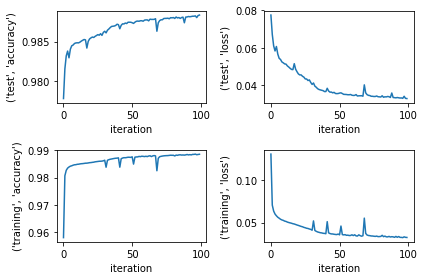

In [10]:
for epoch in tqdm.tnrange(epochs):
    random.shuffle(training_set_keys)

    batch = ()

    for key in tqdm.tqdm_notebook(training_set_keys, leave = False):
        i = random.randint(0, training_set[key].shape[1] - 80)
        batch += (training_set[key][32 : 93, i : i + 80],)

        if len(batch) == batch_size:
            batch = waveCRF.model.xp.array(batch)

            waveCRF.train(batch[:, :, 1:].astype('i'), batch[:, :, None, :-1].astype('f'))

            batch = ()

    for key in tqdm.tqdm_notebook(test_set, leave = False):
        batch = waveCRF.model.xp.array((test_set[key][32 : 93],))

        waveCRF.test(batch[:, :, 1:].astype('i'), batch[:, :, None, :-1].astype('f'))

    IPython.display.clear_output()

    for i, key in enumerate(waveCRF.log):
        matplotlib.pyplot.subplot(221 + i)
        matplotlib.pyplot.plot(numpy.array(waveCRF.log[key]).reshape(epoch + 1, -1).mean(1))
        matplotlib.pyplot.xlabel('iteration')
        matplotlib.pyplot.ylabel(key)

    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()
    os.makedirs('{}/Models/WaveCRF/{}'.format(root, epoch))
    waveCRF.save('{}/Models/WaveCRF/{}'.format(root, epoch))

In [9]:
#Test
# test_set = dict((key, piano_rolls[key]) for key in keys[:int(0.1 * len(keys))])
test_set_keys = list(test_set.keys())

finalModel=WaveCRF()
finalModel.load('{}/Models/WaveCRF/99/'.format(root))
key=88

batch = finalModel.model.xp.array((test_set[test_set_keys[key]][32 : 93],))

sample=finalModel.test(batch.astype('i'), batch[:, :, None, :].astype('f'))

sample.data.shape
sample_soft=F.softmax(sample.data)

print(" ")
print("Sample data =")
print(sample_soft.data)



Q_hat_Call = 
(480, 2, 61)
Q_hat_Test = 
(1, 2, 61, 480)
 
Sample data =
[[[[0.6471877  0.8945902  0.8628485  ... 0.7370715  0.7386817
    0.7351906 ]
   [0.4230899  0.37106222 0.28188002 ... 0.1576974  0.17865069
    0.1546677 ]
   [0.3915952  0.38447952 0.4533446  ... 0.37688506 0.36129954
    0.39464647]
   ...
   [0.65328896 0.77383316 0.7359843  ... 0.8395919  0.7963302
    0.78430045]
   [0.6663335  0.7681202  0.8206296  ... 0.8103605  0.81976104
    0.82973105]
   [0.45095196 0.53779155 0.4286963  ... 0.2035812  0.24096642
    0.23737651]]

  [[0.35281223 0.10540981 0.13715152 ... 0.2629285  0.26131836
    0.2648094 ]
   [0.57691014 0.6289378  0.71812    ... 0.8423026  0.8213493
    0.8453323 ]
   [0.60840476 0.6155205  0.5466554  ... 0.62311494 0.6387005
    0.60535353]
   ...
   [0.34671104 0.22616692 0.26401567 ... 0.1604081  0.20366977
    0.21569948]
   [0.33366647 0.2318798  0.1793704  ... 0.18963952 0.18023893
    0.170269  ]
   [0.54904807 0.46220845 0.57130367 ... 0.796

In [ ]:
import sys
sys.path.append(r"/Users/xiaoxuan/Downloads/midi")

import utils
import numpy as np
import pygame

piano_roll = np.random.rand(61, 79) < .5 
# let's randomly generate some piano roll with 61 notes and 79 time points
print(piano_roll)
print(piano_roll.shape)
sample = np.load("data_nips02.npy")
print(type(sample))
print(sample.shape)
sample1 = sample[0,0,:,:]
print(sample1)
sample2 = sample[0,1,:,:]
print(sample2)

piano_roll = sample1 > .4
utils.midiwrite('piano_roll.mid', piano_roll.T, (32, 93), 0.25) 
'''
pygame.init()
pygame.mixer.init()
pygame.mixer.music.load('piano_roll.mid')
pygame.mixer.music.play()
'''


In [11]:
import IPython
IPython.display.Audio('piano_roll.mid.mp3')

In [ ]:
# 1 begin
# use more layers/ use more quality input / have better loss function
# 1 end
# 2 begin

# the meanfield iterative algorithm for dense CRF converges in less than 10 iterations and it does not suffer from vanishing and exploiding gradient problems.
# shortcomings: 

# 2 end

# 3 begin

# We view the CRF-RNN component as three (message passing/compatibility transform and normalization) layers and analyses their differentiality respectively:
# Message Passing: the error derivatives can be calculated though the Gaussian kernal in inverse direction.
# Compatibility transform: it can be viewed as another convolution layer where the spatial receptive field of the filter is 1*1 and number of input and ouput channels are L.
#       learning the weights of this filter is equivalent to tlearning the label compatibility function \mu. Doing backpropogation here can be done as a usual convolution operation
# Normalization: Differentials at the ouput of this step can be done with softmax operation's backward pass
# Reference: Zheng, Shuai, Sadeep Jayasumana, Bernardino Romera-Paredes, Vibhav Vineet, Zhizhong Su, Dalong Du, Chang Huang, and Philip H. S. Torr. “Conditional Random Fields as Recurrent Neural Networks.” In 2015 IEEE International Conference on Computer Vision (ICCV), 1529–37. Santiago, Chile: IEEE, 2015. https://doi.org/10.1109/ICCV.2015.179.

# 3 end